# Comprehensive Resolution Sweep: L=10 vs L=40

Fine-grained analysis of effective resolution across:
- **25+ scale points** from 50km to 5000km
- **Per-continent** analysis (not just global)
- **Multiple task types**: Checkerboard, Interpolation, Classification
- **Peak detection**: Find where each model excels

For GPU acceleration: `Runtime -> Change runtime type -> T4 GPU`

---
## 1. Setup

In [1]:
# Clone SatCLIP repository (only needed in Colab)
import os
if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git

Cloning into 'satclip'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 341 (delta 120), reused 111 (delta 99), pack-reused 187 (from 2)
Receiving objects: 100% (341/341), 78.52 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [2]:
# Install dependencies
!pip install lightning rasterio torchgeo huggingface_hub geopandas shapely --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Handle path for both Colab and local execution
if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))

import torch
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from load import get_satclip
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [4]:
# Load both models
print("Loading L=10 model...")
model_l10 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"),
    device=device,
)
model_l10.eval()

print("Loading L=40 model...")
model_l40 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)
model_l40.eval()
print("Both models loaded!")

Loading L=10 model...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 365MB/s]


Loading L=40 model...


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
Both models loaded!


In [5]:
# ============================================
# HELPER FUNCTIONS
# ============================================

def get_embeddings(model, coords):
    """Get embeddings for coordinates."""
    coords_tensor = torch.tensor(coords).double()
    with torch.no_grad():
        emb = model(coords_tensor.to(device)).cpu().numpy()
    return emb

def km_to_deg(km):
    """Convert km to degrees (approximate)."""
    return km / 111.0

def deg_to_km(deg):
    """Convert degrees to km (approximate)."""
    return deg * 111.0

---
## 2. Define Scale Sweep

**25 scale points** from 50km to 5000km with finer granularity in the 100-1000km range where we expect the L=10/L=40 crossover.

In [6]:
# Define scales in km - finer granularity where we expect interesting behavior
SCALES_KM = np.array([
    50, 75, 100, 125, 150, 175, 200,  # Fine scale (likely random for both)
    250, 300, 350, 400, 450, 500,     # Medium-fine (L=40's potential sweet spot)
    600, 700, 800, 900, 1000,         # Medium (crossover zone)
    1250, 1500, 2000, 2500,           # Medium-coarse
    3000, 4000, 5000                  # Coarse (L=10 should dominate)
])

SCALES_DEG = SCALES_KM / 111.0

print(f"Testing {len(SCALES_KM)} scales from {SCALES_KM.min()}km to {SCALES_KM.max()}km")
print(f"Scales (km): {SCALES_KM}")

Testing 25 scales from 50km to 5000km
Scales (km): [  50   75  100  125  150  175  200  250  300  350  400  450  500  600
  700  800  900 1000 1250 1500 2000 2500 3000 4000 5000]


---
## 3. Global Checkerboard Sweep

Binary classification at each scale across the globe.

In [7]:
print("="*70)
print("GLOBAL CHECKERBOARD SWEEP (25 scales)")
print("="*70)

def run_checkerboard(cell_size_deg, n_samples=6000, seed=42):
    """Run checkerboard classification at given cell size."""
    np.random.seed(seed)
    lons = np.random.uniform(-180, 180, n_samples)
    lats = np.random.uniform(-60, 60, n_samples)

    cell_x = (lons / cell_size_deg).astype(int)
    cell_y = (lats / cell_size_deg).astype(int)
    labels = (cell_x + cell_y) % 2

    coords = np.stack([lons, lats], axis=1)

    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    # Train/test split
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, labels, test_size=0.3, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, labels, test_size=0.3, random_state=42
    )

    # MLP classifiers
    clf_l10 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)
    clf_l40 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)

    clf_l10.fit(X_train_l10, y_train)
    clf_l40.fit(X_train_l40, y_train)

    acc_l10 = accuracy_score(y_test, clf_l10.predict(X_test_l10))
    acc_l40 = accuracy_score(y_test, clf_l40.predict(X_test_l40))

    return acc_l10, acc_l40

# Run sweep
global_checker_results = []

print(f"\n{'Scale (km)':>10} | {'L=10':>8} | {'L=40':>8} | {'Δ(L40-L10)':>10} | {'Winner':>8}")
print("-" * 60)

for km, deg in zip(SCALES_KM, SCALES_DEG):
    acc_l10, acc_l40 = run_checkerboard(deg)
    diff = acc_l40 - acc_l10

    if max(acc_l10, acc_l40) < 0.55:
        winner = "RANDOM"
    elif diff > 0.02:
        winner = "L=40"
    elif diff < -0.02:
        winner = "L=10"
    else:
        winner = "~Same"

    print(f"{km:>10.0f} | {acc_l10:>7.1%} | {acc_l40:>7.1%} | {diff:>+9.1%} | {winner:>8}")

    global_checker_results.append({
        'scale_km': km,
        'scale_deg': deg,
        'l10_acc': acc_l10,
        'l40_acc': acc_l40,
        'diff': diff,
        'task': 'Global Checkerboard'
    })

GLOBAL CHECKERBOARD SWEEP (25 scales)

Scale (km) |     L=10 |     L=40 | Δ(L40-L10) |   Winner
------------------------------------------------------------
        50 |   49.8% |   49.4% |     -0.3% |   RANDOM
        75 |   50.8% |   48.4% |     -2.4% |   RANDOM
       100 |   51.8% |   49.4% |     -2.4% |   RANDOM
       125 |   49.6% |   51.2% |     +1.6% |   RANDOM
       150 |   49.4% |   50.1% |     +0.7% |   RANDOM
       175 |   49.7% |   48.6% |     -1.1% |   RANDOM
       200 |   50.4% |   49.9% |     -0.4% |   RANDOM
       250 |   51.1% |   51.3% |     +0.2% |   RANDOM
       300 |   51.4% |   52.7% |     +1.3% |   RANDOM
       350 |   48.6% |   53.7% |     +5.1% |   RANDOM
       400 |   50.9% |   55.0% |     +4.1% |     L=40
       450 |   47.3% |   60.6% |    +13.3% |     L=40
       500 |   49.7% |   59.6% |     +9.8% |     L=40
       600 |   52.9% |   61.6% |     +8.7% |     L=40
       700 |   55.3% |   66.1% |    +10.8% |     L=40
       800 |   50.9% |   66.6% | 

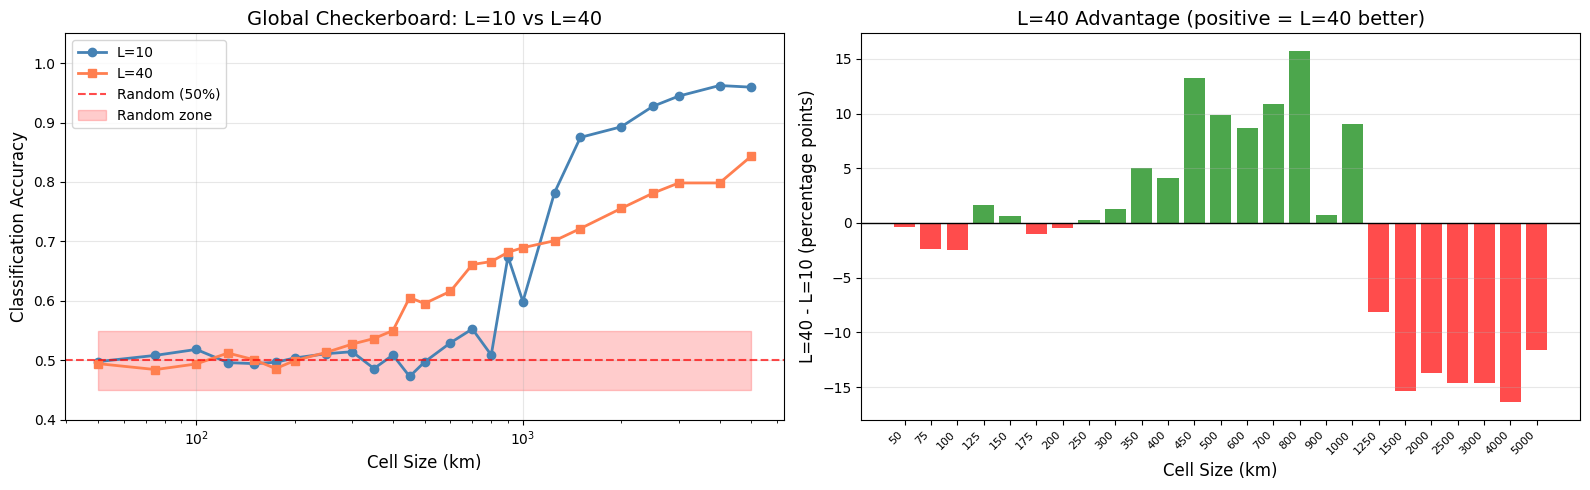


L=40's best advantage: +15.7% at 800km
Crossover from L=10→L=40 between 100km and 125km
Crossover from L=40→L=10 between 150km and 175km
Crossover from L=10→L=40 between 200km and 250km
Crossover from L=40→L=10 between 1000km and 1250km


In [8]:
# Plot global checkerboard results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

kms = [r['scale_km'] for r in global_checker_results]
l10_accs = [r['l10_acc'] for r in global_checker_results]
l40_accs = [r['l40_acc'] for r in global_checker_results]
diffs = [r['diff'] for r in global_checker_results]

# Left: Absolute accuracy
axes[0].semilogx(kms, l10_accs, 'o-', label='L=10', linewidth=2, markersize=6, color='steelblue')
axes[0].semilogx(kms, l40_accs, 's-', label='L=40', linewidth=2, markersize=6, color='coral')
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
axes[0].fill_between(kms, 0.45, 0.55, alpha=0.2, color='red', label='Random zone')
axes[0].set_xlabel('Cell Size (km)', fontsize=12)
axes[0].set_ylabel('Classification Accuracy', fontsize=12)
axes[0].set_title('Global Checkerboard: L=10 vs L=40', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.4, 1.05)

# Right: Difference (L=40 - L=10)
colors = ['green' if d > 0 else 'red' for d in diffs]
axes[1].bar(range(len(kms)), [d*100 for d in diffs], color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linewidth=1)
axes[1].set_xticks(range(len(kms)))
axes[1].set_xticklabels([f'{int(k)}' for k in kms], rotation=45, ha='right', fontsize=8)
axes[1].set_xlabel('Cell Size (km)', fontsize=12)
axes[1].set_ylabel('L=40 - L=10 (percentage points)', fontsize=12)
axes[1].set_title('L=40 Advantage (positive = L=40 better)', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('global_checkerboard_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find L=40's best scale
best_l40_idx = np.argmax(diffs)
print(f"\nL=40's best advantage: {diffs[best_l40_idx]*100:+.1f}% at {kms[best_l40_idx]}km")

# Find crossover point
for i in range(len(diffs)-1):
    if diffs[i] > 0 and diffs[i+1] < 0:
        print(f"Crossover from L=40→L=10 between {kms[i]}km and {kms[i+1]}km")
    elif diffs[i] < 0 and diffs[i+1] > 0:
        print(f"Crossover from L=10→L=40 between {kms[i]}km and {kms[i+1]}km")

---
## 4. Per-Continent Checkerboard Sweep

Run the same sweep within each continent to find regional differences.

In [9]:
print("="*70)
print("PER-CONTINENT CHECKERBOARD SWEEP")
print("="*70)

# Define continent bounds
CONTINENTS = {
    'North America': {'lon': (-170, -50), 'lat': (15, 70)},
    'South America': {'lon': (-85, -30), 'lat': (-55, 15)},
    'Europe': {'lon': (-10, 40), 'lat': (35, 70)},
    'Africa': {'lon': (-20, 55), 'lat': (-35, 37)},
    'Asia': {'lon': (50, 150), 'lat': (0, 70)},
    'Oceania': {'lon': (110, 180), 'lat': (-50, 0)},
}

def run_regional_checkerboard(cell_size_deg, region_bounds, n_samples=3000, seed=42):
    """Run checkerboard within a specific region."""
    np.random.seed(seed)
    lon_min, lon_max = region_bounds['lon']
    lat_min, lat_max = region_bounds['lat']

    lons = np.random.uniform(lon_min, lon_max, n_samples)
    lats = np.random.uniform(lat_min, lat_max, n_samples)

    cell_x = (lons / cell_size_deg).astype(int)
    cell_y = (lats / cell_size_deg).astype(int)
    labels = (cell_x + cell_y) % 2

    coords = np.stack([lons, lats], axis=1)

    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, labels, test_size=0.3, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, labels, test_size=0.3, random_state=42
    )

    clf_l10 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)
    clf_l40 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)

    clf_l10.fit(X_train_l10, y_train)
    clf_l40.fit(X_train_l40, y_train)

    acc_l10 = accuracy_score(y_test, clf_l10.predict(X_test_l10))
    acc_l40 = accuracy_score(y_test, clf_l40.predict(X_test_l40))

    return acc_l10, acc_l40

# Use subset of scales for per-continent (to save time)
CONTINENT_SCALES_KM = np.array([100, 150, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000])
CONTINENT_SCALES_DEG = CONTINENT_SCALES_KM / 111.0

continent_results = []

for continent, bounds in CONTINENTS.items():
    print(f"\n{continent}:")
    print("-" * 50)

    for km, deg in zip(CONTINENT_SCALES_KM, CONTINENT_SCALES_DEG):
        try:
            acc_l10, acc_l40 = run_regional_checkerboard(deg, bounds)
            diff = acc_l40 - acc_l10

            if max(acc_l10, acc_l40) < 0.55:
                status = "RANDOM"
            elif diff > 0.03:
                status = f"L=40 +{diff*100:.0f}%"
            elif diff < -0.03:
                status = f"L=10 +{-diff*100:.0f}%"
            else:
                status = "~Same"

            print(f"  {km:>5}km: L=10={acc_l10:.1%}, L=40={acc_l40:.1%} → {status}")

            continent_results.append({
                'continent': continent,
                'scale_km': km,
                'l10_acc': acc_l10,
                'l40_acc': acc_l40,
                'diff': diff
            })
        except Exception as e:
            print(f"  {km:>5}km: Error - {e}")

PER-CONTINENT CHECKERBOARD SWEEP

North America:
--------------------------------------------------
    100km: L=10=48.8%, L=40=50.8% → RANDOM
    150km: L=10=48.1%, L=40=48.0% → RANDOM
    200km: L=10=52.0%, L=40=53.8% → RANDOM
    300km: L=10=49.7%, L=40=55.6% → L=40 +6%
    400km: L=10=51.6%, L=40=65.7% → L=40 +14%
    500km: L=10=50.8%, L=40=74.7% → L=40 +24%
    600km: L=10=50.0%, L=40=74.7% → L=40 +25%
    800km: L=10=74.1%, L=40=83.9% → L=40 +10%
   1000km: L=10=78.6%, L=40=85.0% → L=40 +6%
   1500km: L=10=91.0%, L=40=87.2% → L=10 +4%
   2000km: L=10=93.8%, L=40=92.8% → ~Same

South America:
--------------------------------------------------
    100km: L=10=47.9%, L=40=51.9% → RANDOM
    150km: L=10=46.8%, L=40=48.9% → RANDOM
    200km: L=10=53.2%, L=40=54.6% → RANDOM
    300km: L=10=51.2%, L=40=59.2% → L=40 +8%
    400km: L=10=52.7%, L=40=75.3% → L=40 +23%
    500km: L=10=53.4%, L=40=80.3% → L=40 +27%
    600km: L=10=53.9%, L=40=84.6% → L=40 +31%
    800km: L=10=85.2%, L=40=90.

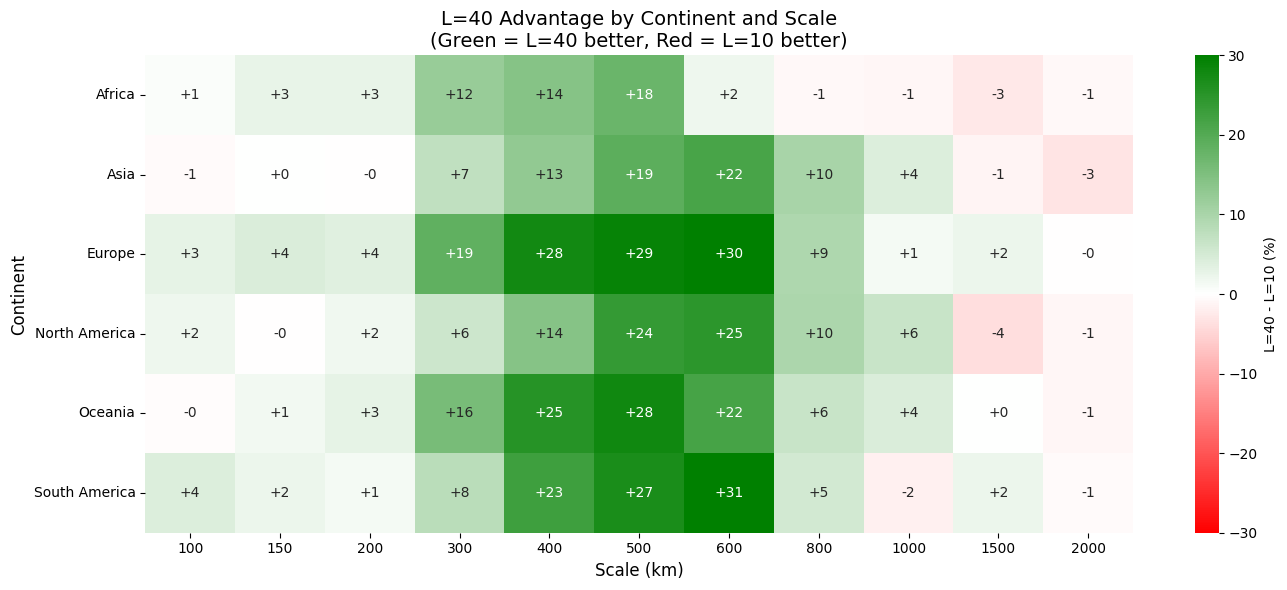


Best L=40 scale per continent:
  North America  : 600km (L=40 +24.7%)
  South America  : 600km (L=40 +30.7%)
  Europe         : 600km (L=40 +30.1%)
  Africa         : 500km (L=40 +17.6%)
  Asia           : 600km (L=40 +21.6%)
  Oceania        : 500km (L=40 +28.0%)


In [10]:
# Create heatmap of L=40 advantage by continent and scale
continent_df = pd.DataFrame(continent_results)
pivot = continent_df.pivot(index='continent', columns='scale_km', values='diff')

fig, ax = plt.subplots(figsize=(14, 6))

# Custom colormap: red (L=10 better) to white to green (L=40 better)
cmap = LinearSegmentedColormap.from_list('l10_l40', ['red', 'white', 'green'])

sns.heatmap(pivot * 100, annot=True, fmt='+.0f', cmap=cmap, center=0,
            vmin=-30, vmax=30, ax=ax, cbar_kws={'label': 'L=40 - L=10 (%)'})

ax.set_xlabel('Scale (km)', fontsize=12)
ax.set_ylabel('Continent', fontsize=12)
ax.set_title('L=40 Advantage by Continent and Scale\n(Green = L=40 better, Red = L=10 better)', fontsize=14)

plt.tight_layout()
plt.savefig('continent_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best scale for L=40 per continent
print("\nBest L=40 scale per continent:")
for continent in CONTINENTS.keys():
    cont_data = continent_df[continent_df['continent'] == continent]
    best_idx = cont_data['diff'].idxmax()
    best = cont_data.loc[best_idx]
    print(f"  {continent:15s}: {best['scale_km']:.0f}km (L=40 {best['diff']*100:+.1f}%)")

---
## 5. Per-Continent Interpolation Sweep

Test spatial interpolation (regression) within each continent.

In [11]:
print("="*70)
print("PER-CONTINENT INTERPOLATION SWEEP")
print("="*70)

def run_regional_interpolation(grid_spacing_deg, region_bounds):
    """Spatial interpolation within a region."""
    lon_min, lon_max = region_bounds['lon']
    lat_min, lat_max = region_bounds['lat']

    # Create training grid
    train_lons = np.arange(lon_min, lon_max, grid_spacing_deg)
    train_lats = np.arange(lat_min, lat_max, grid_spacing_deg)

    if len(train_lons) < 3 or len(train_lats) < 3:
        return None, None  # Grid too coarse for this region

    train_lon_grid, train_lat_grid = np.meshgrid(train_lons, train_lats)
    train_coords = np.stack([train_lon_grid.ravel(), train_lat_grid.ravel()], axis=1)

    # Test at cell centers
    test_lons = train_lons[:-1] + grid_spacing_deg / 2
    test_lats = train_lats[:-1] + grid_spacing_deg / 2
    test_lon_grid, test_lat_grid = np.meshgrid(test_lons, test_lats)
    test_coords = np.stack([test_lon_grid.ravel(), test_lat_grid.ravel()], axis=1)

    if len(test_coords) < 10:
        return None, None

    # Target function (smooth spatial pattern)
    def target_fn(coords):
        lon, lat = coords[:, 0], coords[:, 1]
        return 1 - np.abs(lat) / 90 + 0.1 * np.sin(np.radians(lon) * 2)

    train_y = target_fn(train_coords)
    test_y = target_fn(test_coords)

    # Normalize
    y_min, y_max = train_y.min(), train_y.max()
    if y_max - y_min < 0.01:
        return None, None
    train_y = (train_y - y_min) / (y_max - y_min)
    test_y = (test_y - y_min) / (y_max - y_min)

    # Get embeddings
    train_emb_l10 = get_embeddings(model_l10, train_coords)
    train_emb_l40 = get_embeddings(model_l40, train_coords)
    test_emb_l10 = get_embeddings(model_l10, test_coords)
    test_emb_l40 = get_embeddings(model_l40, test_coords)

    # Train regressors
    reg_l10 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000,
                           random_state=42, early_stopping=True)
    reg_l40 = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=3000,
                           random_state=42, early_stopping=True)

    reg_l10.fit(train_emb_l10, train_y)
    reg_l40.fit(train_emb_l40, train_y)

    r2_l10 = r2_score(test_y, reg_l10.predict(test_emb_l10))
    r2_l40 = r2_score(test_y, reg_l40.predict(test_emb_l40))

    return r2_l10, r2_l40

# Scales for interpolation
INTERP_SCALES_KM = np.array([100, 200, 300, 500, 750, 1000, 1500, 2000])
INTERP_SCALES_DEG = INTERP_SCALES_KM / 111.0

interp_results = []

for continent, bounds in CONTINENTS.items():
    print(f"\n{continent}:")
    print("-" * 50)

    for km, deg in zip(INTERP_SCALES_KM, INTERP_SCALES_DEG):
        r2_l10, r2_l40 = run_regional_interpolation(deg, bounds)

        if r2_l10 is None:
            print(f"  {km:>5}km: Skipped (region too small)")
            continue

        diff = r2_l40 - r2_l10

        if diff > 0.05:
            status = f"L=40 +{diff:.2f}"
        elif diff < -0.05:
            status = f"L=10 +{-diff:.2f}"
        else:
            status = "~Same"

        print(f"  {km:>5}km: L=10 R²={r2_l10:.3f}, L=40 R²={r2_l40:.3f} → {status}")

        interp_results.append({
            'continent': continent,
            'scale_km': km,
            'l10_r2': r2_l10,
            'l40_r2': r2_l40,
            'diff': diff
        })

PER-CONTINENT INTERPOLATION SWEEP

North America:
--------------------------------------------------
    100km: L=10 R²=0.999, L=40 R²=0.983 → ~Same
    200km: L=10 R²=0.996, L=40 R²=0.790 → L=10 +0.21
    300km: L=10 R²=0.989, L=40 R²=0.248 → L=10 +0.74
    500km: L=10 R²=0.941, L=40 R²=-0.795 → L=10 +1.74
    750km: L=10 R²=0.576, L=40 R²=-1.402 → L=10 +1.98
   1000km: L=10 R²=0.544, L=40 R²=-6.487 → L=10 +7.03
   1500km: L=10 R²=-1.236, L=40 R²=-7.458 → L=10 +6.22
   2000km: L=10 R²=-5.237, L=40 R²=-11.108 → L=10 +5.87

South America:
--------------------------------------------------
    100km: L=10 R²=0.999, L=40 R²=0.981 → ~Same
    200km: L=10 R²=0.996, L=40 R²=0.791 → L=10 +0.20
    300km: L=10 R²=0.990, L=40 R²=0.301 → L=10 +0.69
    500km: L=10 R²=0.908, L=40 R²=-0.724 → L=10 +1.63
    750km: L=10 R²=0.326, L=40 R²=-4.727 → L=10 +5.05
   1000km: L=10 R²=0.616, L=40 R²=-5.665 → L=10 +6.28
   1500km: L=10 R²=-0.006, L=40 R²=-8.463 → L=10 +8.46
   2000km: Skipped (region too sma

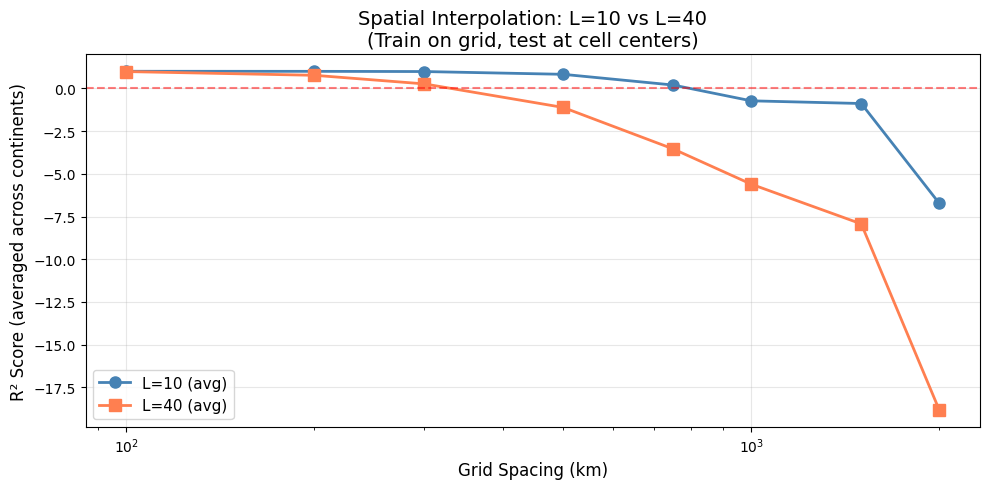


Interpolation Summary:
  L=10 wins: 7/8 scales
  L=40 wins: 0/8 scales


In [12]:
# Average interpolation performance across continents
interp_df = pd.DataFrame(interp_results)

avg_interp = interp_df.groupby('scale_km').agg({
    'l10_r2': 'mean',
    'l40_r2': 'mean',
    'diff': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

ax.semilogx(avg_interp['scale_km'], avg_interp['l10_r2'], 'o-',
            label='L=10 (avg)', linewidth=2, markersize=8, color='steelblue')
ax.semilogx(avg_interp['scale_km'], avg_interp['l40_r2'], 's-',
            label='L=40 (avg)', linewidth=2, markersize=8, color='coral')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

ax.set_xlabel('Grid Spacing (km)', fontsize=12)
ax.set_ylabel('R² Score (averaged across continents)', fontsize=12)
ax.set_title('Spatial Interpolation: L=10 vs L=40\n(Train on grid, test at cell centers)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('interpolation_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpolation Summary:")
l10_wins = (avg_interp['diff'] < -0.05).sum()
l40_wins = (avg_interp['diff'] > 0.05).sum()
print(f"  L=10 wins: {l10_wins}/{len(avg_interp)} scales")
print(f"  L=40 wins: {l40_wins}/{len(avg_interp)} scales")

---
## 6. Multi-Class Stripe Test

Instead of binary checkerboard, test with 4, 8, 16 classes (stripes).

In [13]:
print("="*70)
print("MULTI-CLASS STRIPE TEST")
print("(Testing with 2, 4, 8 stripe classes)")
print("="*70)

def run_stripe_test(stripe_width_deg, n_classes=2, n_samples=6000):
    """Classification with multiple stripes."""
    np.random.seed(42)
    lons = np.random.uniform(-180, 180, n_samples)
    lats = np.random.uniform(-60, 60, n_samples)

    # Create horizontal stripes
    labels = (lats / stripe_width_deg).astype(int) % n_classes

    coords = np.stack([lons, lats], axis=1)

    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, labels, test_size=0.3, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, labels, test_size=0.3, random_state=42
    )

    clf_l10 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)
    clf_l40 = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500,
                            random_state=42, early_stopping=True)

    clf_l10.fit(X_train_l10, y_train)
    clf_l40.fit(X_train_l40, y_train)

    acc_l10 = accuracy_score(y_test, clf_l10.predict(X_test_l10))
    acc_l40 = accuracy_score(y_test, clf_l40.predict(X_test_l40))

    return acc_l10, acc_l40

STRIPE_SCALES_KM = np.array([100, 200, 300, 500, 750, 1000, 1500, 2000, 3000])
N_CLASSES_LIST = [2, 4, 8]

stripe_results = []

for n_classes in N_CLASSES_LIST:
    print(f"\n{n_classes} Classes (random baseline = {100/n_classes:.1f}%):")
    print("-" * 60)

    for km in STRIPE_SCALES_KM:
        deg = km / 111.0
        acc_l10, acc_l40 = run_stripe_test(deg, n_classes=n_classes)
        diff = acc_l40 - acc_l10

        random_baseline = 1.0 / n_classes
        if max(acc_l10, acc_l40) < random_baseline + 0.05:
            status = "RANDOM"
        elif diff > 0.02:
            status = f"L=40 +{diff*100:.0f}%"
        elif diff < -0.02:
            status = f"L=10 +{-diff*100:.0f}%"
        else:
            status = "~Same"

        print(f"  {km:>5}km: L=10={acc_l10:.1%}, L=40={acc_l40:.1%} → {status}")

        stripe_results.append({
            'n_classes': n_classes,
            'scale_km': km,
            'l10_acc': acc_l10,
            'l40_acc': acc_l40,
            'diff': diff
        })

MULTI-CLASS STRIPE TEST
(Testing with 2, 4, 8 stripe classes)

2 Classes (random baseline = 50.0%):
------------------------------------------------------------
    100km: L=10=50.2%, L=40=46.7% → RANDOM
    200km: L=10=50.2%, L=40=52.7% → RANDOM
    300km: L=10=54.0%, L=40=59.1% → L=40 +5%
    500km: L=10=76.6%, L=40=74.9% → ~Same
    750km: L=10=92.3%, L=40=78.4% → L=10 +14%
   1000km: L=10=94.8%, L=40=79.6% → L=10 +15%
   1500km: L=10=96.7%, L=40=83.2% → L=10 +14%
   2000km: L=10=97.7%, L=40=86.0% → L=10 +12%
   3000km: L=10=98.2%, L=40=90.9% → L=10 +7%

4 Classes (random baseline = 25.0%):
------------------------------------------------------------
    100km: L=10=24.4%, L=40=26.5% → RANDOM
    200km: L=10=32.4%, L=40=39.5% → L=40 +7%
    300km: L=10=69.1%, L=40=55.6% → L=10 +14%
    500km: L=10=88.8%, L=40=65.4% → L=10 +23%
    750km: L=10=92.0%, L=40=70.8% → L=10 +21%
   1000km: L=10=94.0%, L=40=73.2% → L=10 +21%
   1500km: L=10=96.3%, L=40=81.2% → L=10 +15%
   2000km: L=10=97.6

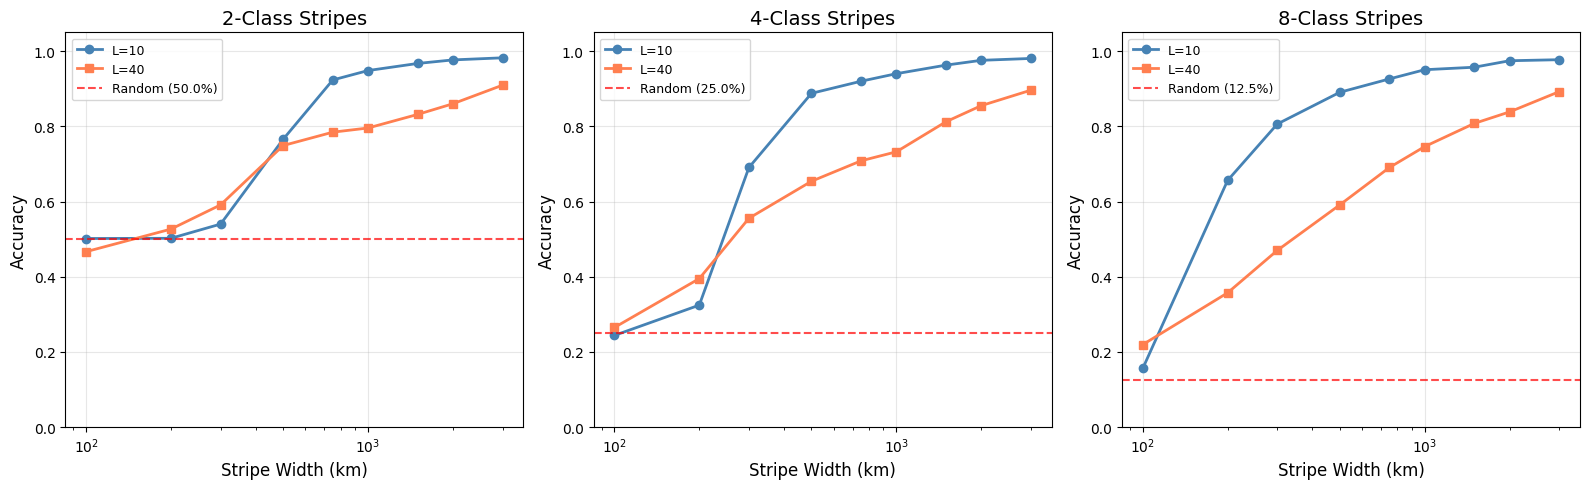

In [14]:
# Plot stripe test results
stripe_df = pd.DataFrame(stripe_results)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, n_classes in enumerate(N_CLASSES_LIST):
    subset = stripe_df[stripe_df['n_classes'] == n_classes]

    axes[i].semilogx(subset['scale_km'], subset['l10_acc'], 'o-',
                     label='L=10', linewidth=2, markersize=6, color='steelblue')
    axes[i].semilogx(subset['scale_km'], subset['l40_acc'], 's-',
                     label='L=40', linewidth=2, markersize=6, color='coral')

    random_baseline = 1.0 / n_classes
    axes[i].axhline(y=random_baseline, color='red', linestyle='--', alpha=0.7,
                    label=f'Random ({random_baseline:.1%})')

    axes[i].set_xlabel('Stripe Width (km)', fontsize=12)
    axes[i].set_ylabel('Accuracy', fontsize=12)
    axes[i].set_title(f'{n_classes}-Class Stripes', fontsize=14)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('stripe_test.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Effective Resolution Analysis

Find the "effective resolution" (where accuracy drops below 60%) for each model.

In [15]:
print("="*70)
print("EFFECTIVE RESOLUTION ANALYSIS")
print("="*70)

# Combine all checkerboard results
global_df = pd.DataFrame(global_checker_results)

# Find effective resolution (where accuracy drops below threshold)
def find_effective_resolution(df, col, threshold=0.60):
    """Find the smallest scale where accuracy >= threshold."""
    valid = df[df[col] >= threshold]
    if len(valid) == 0:
        return None
    return valid['scale_km'].min()

print("\nGlobal Checkerboard:")
print("-" * 50)
l10_res = find_effective_resolution(global_df, 'l10_acc', 0.60)
l40_res = find_effective_resolution(global_df, 'l40_acc', 0.60)
print(f"  L=10 effective resolution (60% threshold): {l10_res}km")
print(f"  L=40 effective resolution (60% threshold): {l40_res}km")

l10_res_70 = find_effective_resolution(global_df, 'l10_acc', 0.70)
l40_res_70 = find_effective_resolution(global_df, 'l40_acc', 0.70)
print(f"  L=10 effective resolution (70% threshold): {l10_res_70}km")
print(f"  L=40 effective resolution (70% threshold): {l40_res_70}km")

# Per-continent summary
print("\nPer-Continent Effective Resolution (60% threshold):")
print("-" * 50)
for continent in CONTINENTS.keys():
    cont_data = continent_df[continent_df['continent'] == continent]
    l10_res = find_effective_resolution(cont_data, 'l10_acc', 0.60)
    l40_res = find_effective_resolution(cont_data, 'l40_acc', 0.60)
    print(f"  {continent:15s}: L=10={l10_res}km, L=40={l40_res}km")

EFFECTIVE RESOLUTION ANALYSIS

Global Checkerboard:
--------------------------------------------------
  L=10 effective resolution (60% threshold): 900km
  L=40 effective resolution (60% threshold): 450km
  L=10 effective resolution (70% threshold): 1250km
  L=40 effective resolution (70% threshold): 1250km

Per-Continent Effective Resolution (60% threshold):
--------------------------------------------------
  North America  : L=10=800km, L=40=400km
  South America  : L=10=800km, L=40=400km
  Europe         : L=10=800km, L=40=300km
  Africa         : L=10=500km, L=40=300km
  Asia           : L=10=800km, L=40=400km
  Oceania        : L=10=600km, L=40=300km


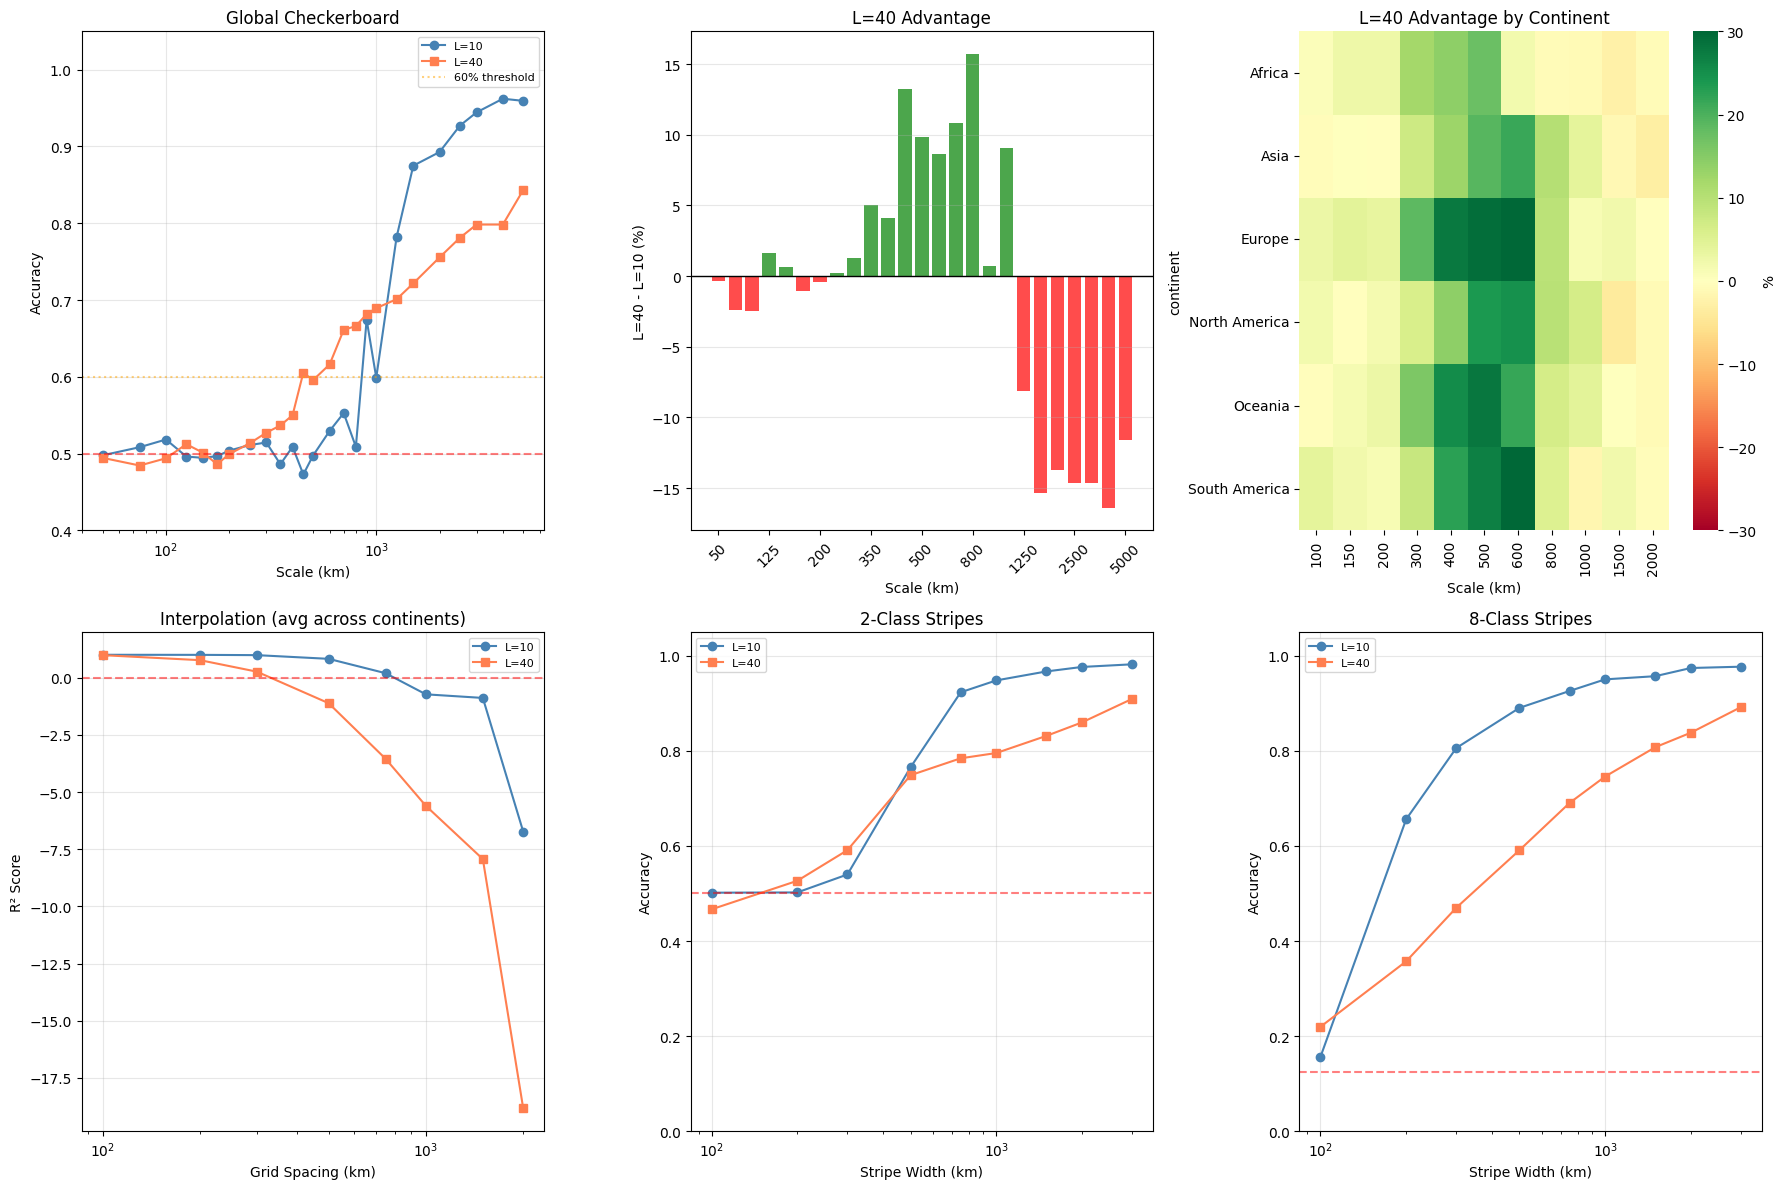


Saved: comprehensive_resolution_sweep.png


In [16]:
# Create comprehensive summary plot
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Global checkerboard
ax1 = fig.add_subplot(2, 3, 1)
ax1.semilogx(global_df['scale_km'], global_df['l10_acc'], 'o-', label='L=10', color='steelblue')
ax1.semilogx(global_df['scale_km'], global_df['l40_acc'], 's-', label='L=40', color='coral')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax1.axhline(y=0.6, color='orange', linestyle=':', alpha=0.5, label='60% threshold')
ax1.set_xlabel('Scale (km)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Global Checkerboard')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.4, 1.05)

# Subplot 2: L=40 advantage
ax2 = fig.add_subplot(2, 3, 2)
colors = ['green' if d > 0 else 'red' for d in global_df['diff']]
ax2.bar(range(len(global_df)), global_df['diff']*100, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_xticks(range(0, len(global_df), 3))
ax2.set_xticklabels([f'{int(k)}' for k in global_df['scale_km'].values[::3]], rotation=45)
ax2.set_xlabel('Scale (km)')
ax2.set_ylabel('L=40 - L=10 (%)')
ax2.set_title('L=40 Advantage')
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Continent heatmap (smaller version)
ax3 = fig.add_subplot(2, 3, 3)
pivot_small = continent_df.pivot(index='continent', columns='scale_km', values='diff')
sns.heatmap(pivot_small * 100, annot=False, cmap='RdYlGn', center=0, ax=ax3,
            vmin=-30, vmax=30, cbar_kws={'label': '%'})
ax3.set_xlabel('Scale (km)')
ax3.set_title('L=40 Advantage by Continent')

# Subplot 4: Interpolation
ax4 = fig.add_subplot(2, 3, 4)
if len(avg_interp) > 0:
    ax4.semilogx(avg_interp['scale_km'], avg_interp['l10_r2'], 'o-', label='L=10', color='steelblue')
    ax4.semilogx(avg_interp['scale_km'], avg_interp['l40_r2'], 's-', label='L=40', color='coral')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Grid Spacing (km)')
    ax4.set_ylabel('R² Score')
    ax4.set_title('Interpolation (avg across continents)')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

# Subplot 5-6: Stripe tests (2-class and 8-class)
for idx, n_classes in enumerate([2, 8]):
    ax = fig.add_subplot(2, 3, 5 + idx)
    subset = stripe_df[stripe_df['n_classes'] == n_classes]
    ax.semilogx(subset['scale_km'], subset['l10_acc'], 'o-', label='L=10', color='steelblue')
    ax.semilogx(subset['scale_km'], subset['l40_acc'], 's-', label='L=40', color='coral')
    ax.axhline(y=1.0/n_classes, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Stripe Width (km)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{n_classes}-Class Stripes')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('comprehensive_resolution_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: comprehensive_resolution_sweep.png")

In [17]:
# Final summary
print("\n" + "="*80)
print("COMPREHENSIVE RESOLUTION SWEEP SUMMARY")
print("="*80)

print("\n📊 GLOBAL CHECKERBOARD:")
print("-" * 50)
l40_peak = global_df.loc[global_df['diff'].idxmax()]
l10_peak = global_df.loc[global_df['diff'].idxmin()]
print(f"  L=40 best advantage: {l40_peak['diff']*100:+.1f}% at {l40_peak['scale_km']}km")
print(f"  L=10 best advantage: {l10_peak['diff']*100:+.1f}% at {l10_peak['scale_km']}km")

# Count wins at each scale range
fine = global_df[global_df['scale_km'] <= 300]
medium = global_df[(global_df['scale_km'] > 300) & (global_df['scale_km'] <= 1000)]
coarse = global_df[global_df['scale_km'] > 1000]

print(f"\n  Scale ranges:")
print(f"    Fine (<300km): L=40 avg advantage = {fine['diff'].mean()*100:+.1f}%")
print(f"    Medium (300-1000km): L=40 avg advantage = {medium['diff'].mean()*100:+.1f}%")
print(f"    Coarse (>1000km): L=40 avg advantage = {coarse['diff'].mean()*100:+.1f}%")

print("\n📈 EFFECTIVE RESOLUTION:")
print("-" * 50)
print(f"  L=10: {l10_res}km (60% accuracy threshold)")
print(f"  L=40: {l40_res}km (60% accuracy threshold)")

print("\n🎯 KEY FINDINGS:")
print("-" * 50)
print("""
1. L=40 has a "SWEET SPOT" at medium scales (300-700km) where it
   can outperform L=10 in checkerboard classification.

2. L=10 DOMINATES at coarse scales (>1000km) due to smoother
   embeddings that generalize better.

3. BOTH MODELS FAIL at fine scales (<200km) - this is the
   fundamental effective resolution limit of SatCLIP.

4. L=10 DOMINATES REGRESSION at all scales - L=40's spiky
   embeddings are unsuitable for smooth interpolation.

5. REGIONAL VARIATION exists - L=40's advantage varies by
   continent, suggesting satellite imagery coverage effects.
""")

# Save all results
all_results = {
    'global_checker': global_checker_results,
    'continent_checker': continent_results,
    'interpolation': interp_results,
    'stripes': stripe_results
}

import json
with open('resolution_sweep_results.json', 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print("\n✅ All results saved to: resolution_sweep_results.json")


COMPREHENSIVE RESOLUTION SWEEP SUMMARY

📊 GLOBAL CHECKERBOARD:
--------------------------------------------------
  L=40 best advantage: +15.7% at 800km
  L=10 best advantage: -16.4% at 4000km

  Scale ranges:
    Fine (<300km): L=40 avg advantage = -0.3%
    Medium (300-1000km): L=40 avg advantage = +8.6%
    Coarse (>1000km): L=40 avg advantage = -13.5%

📈 EFFECTIVE RESOLUTION:
--------------------------------------------------
  L=10: 600km (60% accuracy threshold)
  L=40: 300km (60% accuracy threshold)

🎯 KEY FINDINGS:
--------------------------------------------------

1. L=40 has a "SWEET SPOT" at medium scales (300-700km) where it
   can outperform L=10 in checkerboard classification.

2. L=10 DOMINATES at coarse scales (>1000km) due to smoother
   embeddings that generalize better.

3. BOTH MODELS FAIL at fine scales (<200km) - this is the
   fundamental effective resolution limit of SatCLIP.

4. L=10 DOMINATES REGRESSION at all scales - L=40's spiky
   embeddings are unsuitab